In [2]:
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, silhouette_score
import IPython.display as ipd
import plotly.express as px
import plotly.graph_objs as go
from sklearn.impute import KNNImputer
from tqdm import tqdm
import warnings
import scipy.cluster.hierarchy as shc
from plotly.offline import init_notebook_mode

tqdm.pandas()
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
init_notebook_mode(connected=True)

# Hindi Speech Processing using Unsupervised Learning Techniques
- Unsupervised learning is a type of algorithm that learns patterns from untagged data. The hope is that through mimicry, which is an important mode of learning in people, the machine is forced to build a compact internal representation of its world and then generate imaginative content from it.
- Here since the audio files can be of varying lengths, we need to find some feature extraction methods which captures the same amount of variance and also groups the data by some natural inherent behaviour

<img src="https://developer-blogs.nvidia.com/wp-content/uploads/2019/12/automatic-speech-recognition_updated.png">

# Data Import

In [3]:
directory = '../input/hindi-speech-classification/dataset/train'

In [4]:
data = pd.read_csv("../input/hindi-speech-classification/dataset/train.csv")
data['file_id']+='.mp3'
data['file_id'] = data['file_id'].apply(lambda x: os.path.join(directory,x))
data

,file_id,gender
0,../input/hindi-speech-classification/dataset/t...,male
1,../input/hindi-speech-classification/dataset/t...,male
2,../input/hindi-speech-classification/dataset/t...,male
3,../input/hindi-speech-classification/dataset/t...,female
4,../input/hindi-speech-classification/dataset/t...,male
...,...,...
1993,../input/hindi-speech-classification/dataset/t...,male
1994,../input/hindi-speech-classification/dataset/t...,male
1995,../input/hindi-speech-classification/dataset/t...,male
1996,../input/hindi-speech-classification/dataset/t...,male


# Exploration and Visualization

## Class Distribution
- More number of male speakers present in the data compared to female
- Since there is an imbalance in the data with respect to gender, and the spoken audio signals of both the genders are found to be significantly different, the clusters found using the unsupervised learning algorithms should also show a similar kind of distribution

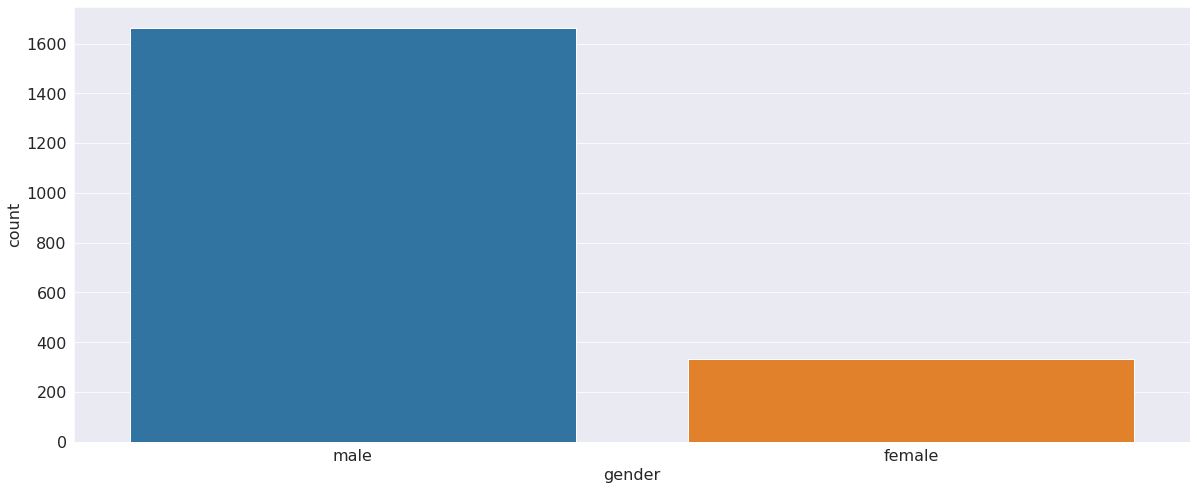

In [5]:
sns.countplot(data['gender'])
plt.show()

In [6]:
def zcr_plot(path, target):
    x , sr = librosa.load(path)
    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.title('Zero Crossing Rate of Gender: '+target)
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()

In [7]:
male = data[data['gender']=='male'].sample(1).iloc[0].file_id
female = data[data['gender']=='female'].sample(1).iloc[0].file_id

In [8]:
ipd.Audio(male)

## Zero Crossing Rates
- The zero crossing rates give a very clear indication of the presence of human speech in an audio
- Since both the samples taken have different intentions behind their respective speeches it can be observed that the zero crossing rate is high at different points which might be the point in time where the male or the female are stressing on some word/phoneme of the speech

Sum of zero crossing  15549


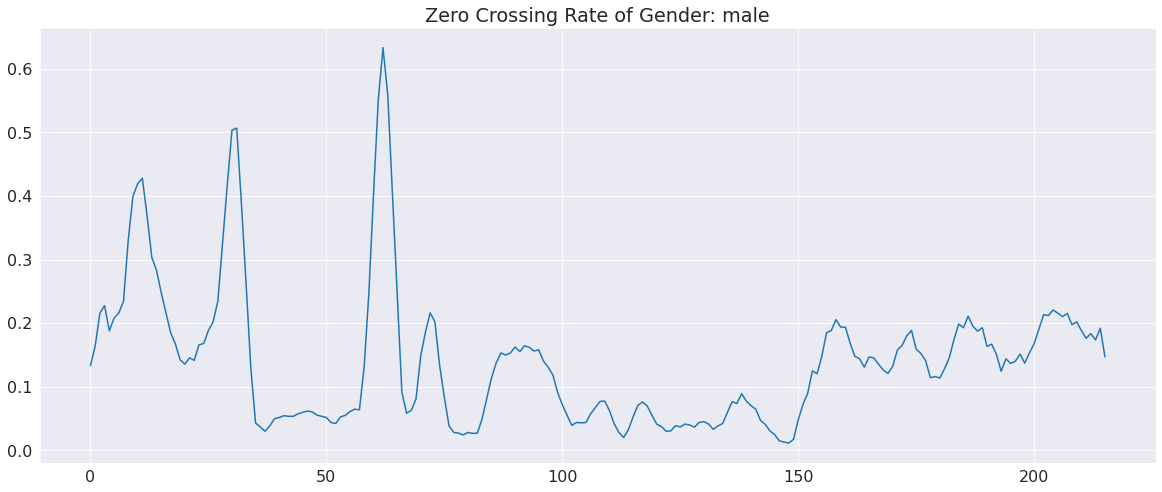

In [9]:
zcr_plot(male,'male')

In [10]:
ipd.Audio(female)

Sum of zero crossing  6629


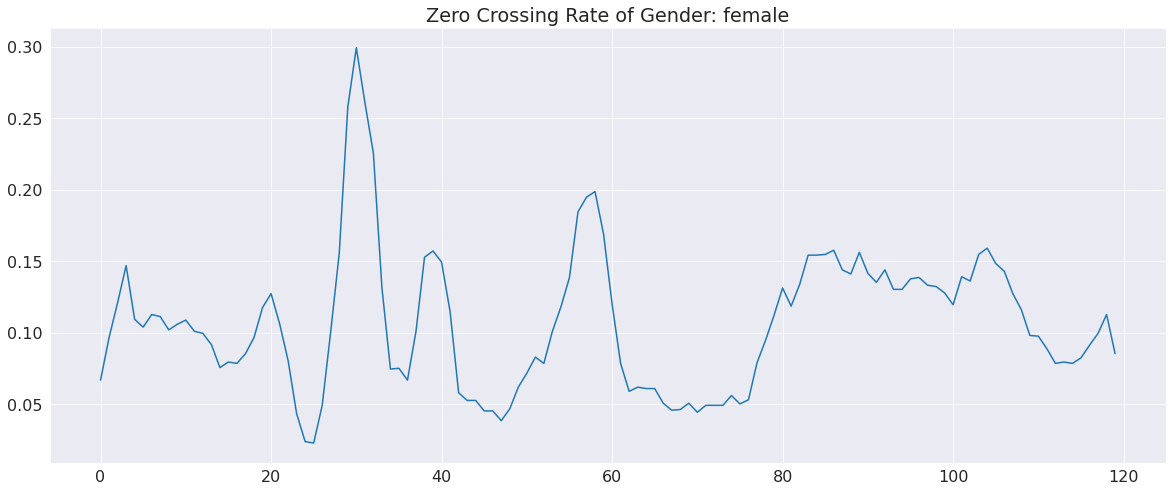

In [11]:
zcr_plot(female,'female')

# Feature Extraction

In [12]:
def get_zcrs(path):
    zcrs = []
    try:
        x , sr = librosa.load(path, res_type='kaiser_fast')
        zcrs = librosa.feature.zero_crossing_rate(x)[0]
    except:
        pass
    return zcrs

In [13]:
X = pd.DataFrame(data['file_id'].progress_apply(lambda x: get_zcrs(x)).tolist())

100%|██████████| 1998/1998 [18:11<00:00,  1.83it/s]


In [14]:
X_knn_ip = X.copy()
X_zero_ip = X.copy()

In [15]:
X.isnull().sum()

0         0
1         0
2         0
3         0
4         0
       ... 
434    1996
435    1996
436    1996
437    1996
438    1997
Length: 439, dtype: int64

## Data Imputation
- Imputing the missing values with naive 0 filling
- Imputing the missing values with KNN based approach

In [16]:
imputer = KNNImputer(n_neighbors=5)
X_zero_ip.fillna(value=0,inplace=True)
X_knn_ip = imputer.fit_transform(X_knn_ip)
X_knn_ip = pd.DataFrame(X_knn_ip)

y = data['gender']

## Feature Multicollinearity
- Multicollinearity refers to the high correlation between two or more explanatory variables, i.e. predictors.
- High multicollinearity can be observed in KNN imputed data, therefore a dimensionality reduction technique like PCA will work well on it

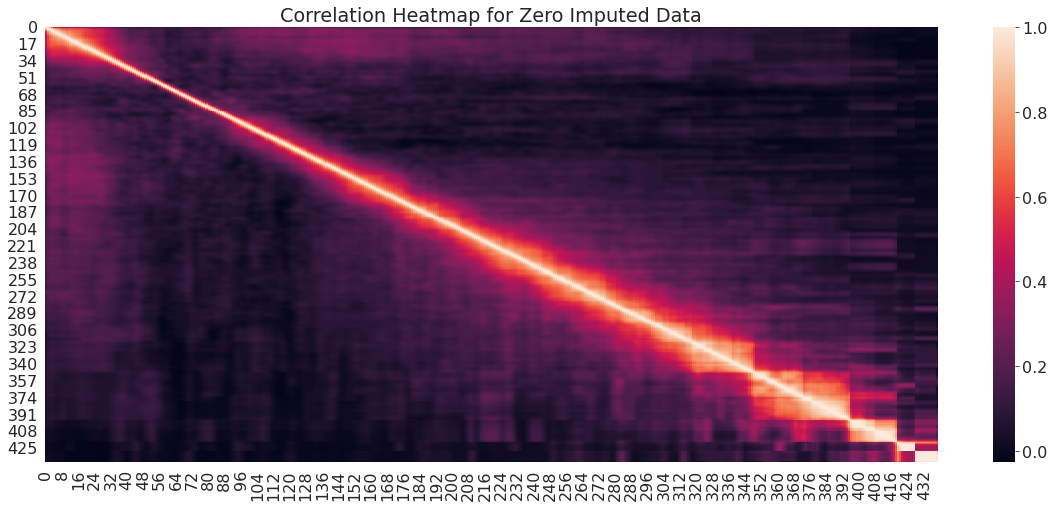

In [17]:
sns.heatmap(X_zero_ip.corr())
plt.title("Correlation Heatmap for Zero Imputed Data")
plt.show()

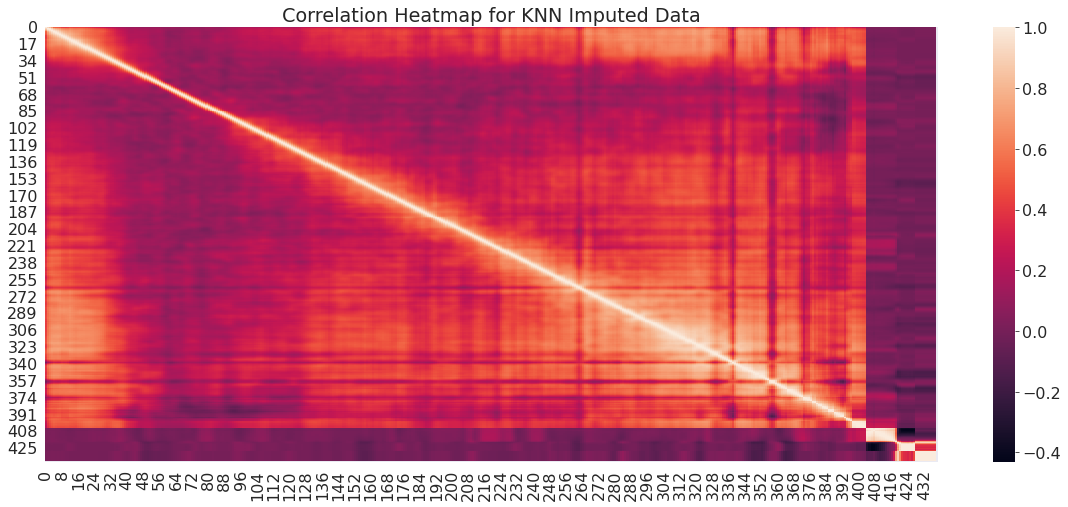

In [18]:
sns.heatmap(X_knn_ip.corr())
plt.title("Correlation Heatmap for KNN Imputed Data")
plt.show()

## Unsupervised Modelling
- Since we want to identify the naturally ocurring patterns within the data we first need to address the varying time length issue using dimensionality reduction
- With the reduced dimensions where the variance explanation is fixed we can then move on to cluster our data

In [19]:
def PrincipalComponentsAnalysis(X):
    pca = PCA()
    X_pca = pca.fit_transform(X)
    variance_explained = np.cumsum(pca.explained_variance_ratio_)
    pcs = range(1,len(variance_explained)+1)
    fig = px.line(x = pcs, y = variance_explained, title = 'Principal Components Cumulative Explained Variance', height=600,  labels={
                         "x": "Principal Components",
                         "y": "Explained Variance"})
    fig.show()
    
    return X_pca

def tSNE(X):
    tsne = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=3)
    X_tsne = tsne.fit_transform(X)
    return X_tsne

def kmeans_wcss(X,clusters):
    opt_val = []
    for i in range(1, clusters+1):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(X)
        opt_val.append(kmeans.inertia_)
        
    fig = px.line(x = range(1, clusters+1), y = opt_val, title = 'KMeans Elbow Method', height=600,  labels={
                     "x": "Number of Clusters",
                     "y": "WCSS"})
    fig.show()
    
def Cluster3D(X,y):
    trace1 = go.Scatter3d(
    x= X[:,0],
    y= X[:,1],
    z= X[:,2],
    mode='markers',
     marker=dict(
        color = y, 
        size= 10,
        line=dict(
            color= y,
            width= 12
        ),
        opacity=0.8
     )
    )
    data_plotly = [trace1]
    layout = go.Layout(
        title= 'Clusters Formed w.r.t.  3 Principal Components',
        scene = dict(
                xaxis = dict(title  = 'PCA 0'),
                yaxis = dict(title  = 'PCA 1'),
                zaxis = dict(title  = 'PCA 2')
            )
    )
    fig = go.Figure(data=data_plotly, layout=layout)
    fig.show()

## PCA (Zero Imputed data)

<img src="https://miro.medium.com/max/1400/1*37a_i1t1tDxDYT3ZI6Yn8w.gif">

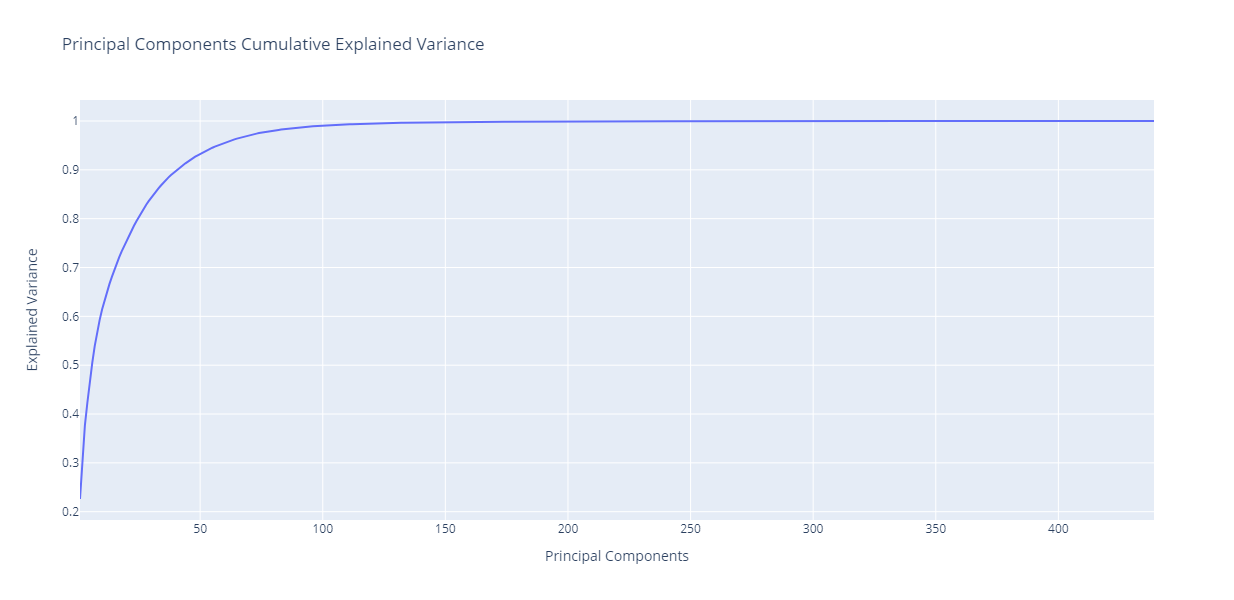

In [20]:
X_pcs_1 = PrincipalComponentsAnalysis(X_zero_ip)

## K-Means Clustering
- k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.

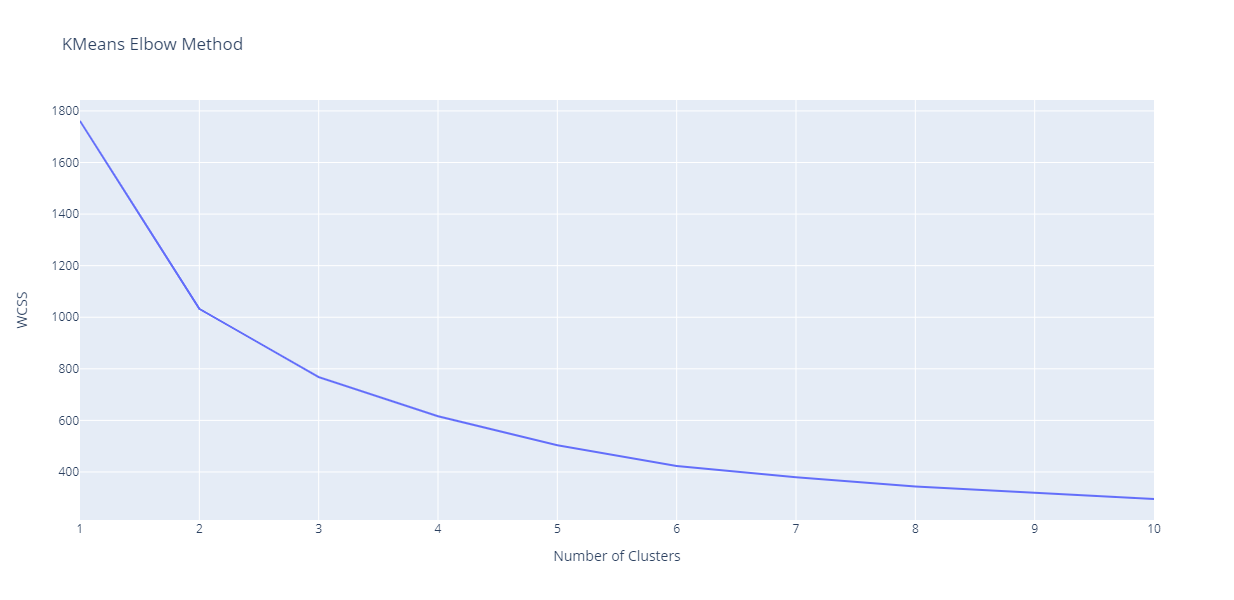

In [21]:
kmeans_wcss(X_pcs_1[:,:3],10)

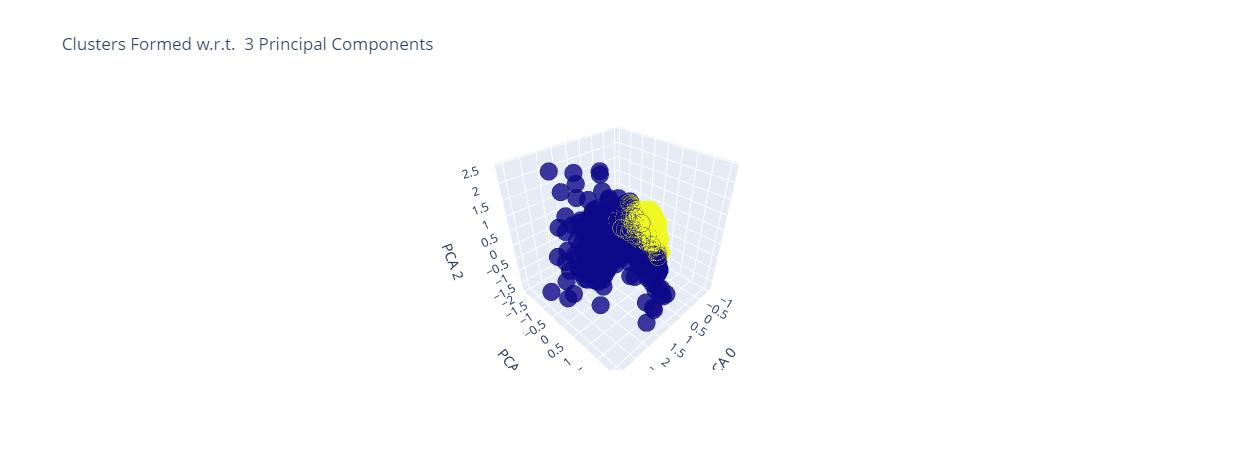

Silhouette Score:	 0.4348146257084641


In [22]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
kmeans.fit(X_pcs_1[:,:3])
y_label = kmeans.predict(X_pcs_1[:,:3])

Cluster3D(X_pcs_1,y_label)
print("Silhouette Score:\t",silhouette_score(X_pcs_1[:,:3], y_label))

## t-SNE (Zero Imputed Data)

<img src="https://miro.medium.com/max/1400/1*KNd4MHXTm6rre2RFZMnpFA.gif">

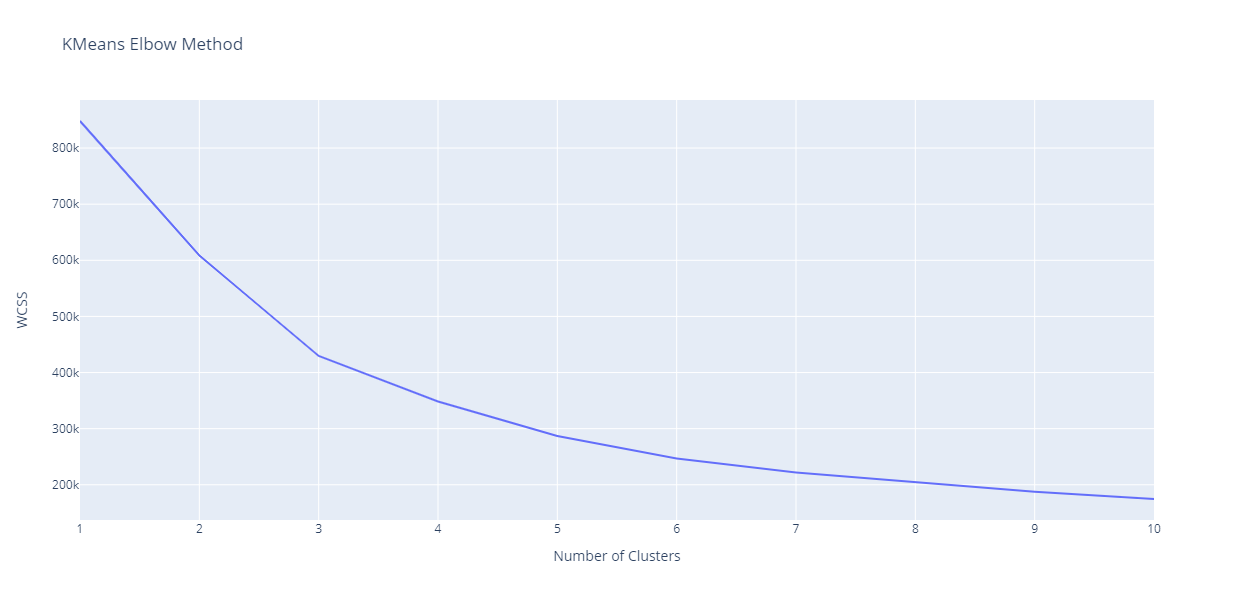

In [23]:
X_tsne = tSNE(X_zero_ip.iloc[:,:-1])
kmeans_wcss(X_tsne,10)

In [24]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
kmeans.fit(X_tsne)
y_label = kmeans.predict(X_tsne)

Cluster3D(X_tsne,y_label)
print("Silhouette Score:\t",silhouette_score(X_tsne, y_label))

Silhouette Score:	 0.26772165


| Clustering | Silhouette Score |
| --- | --- |
| Kmeans on PCA (3PC) | 0.4348 |
| Kmeans on TSNE | 0.2702 |

## PCA (KNN Imputed Data)

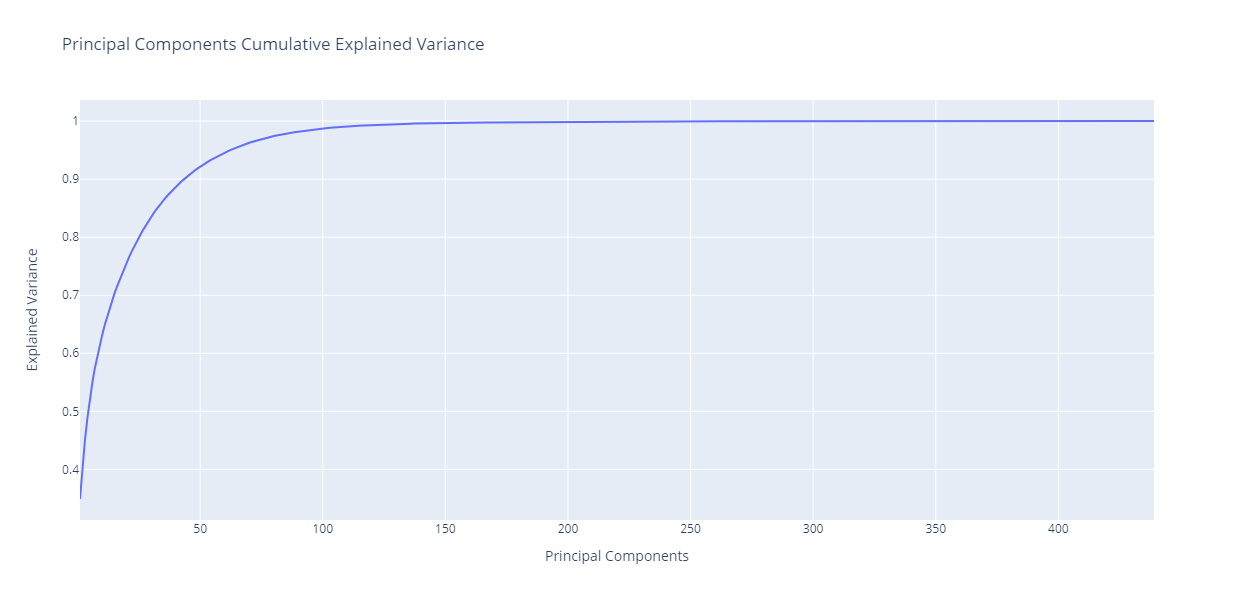

In [25]:
X_pcs_2 = PrincipalComponentsAnalysis(X_knn_ip)

## K-Means

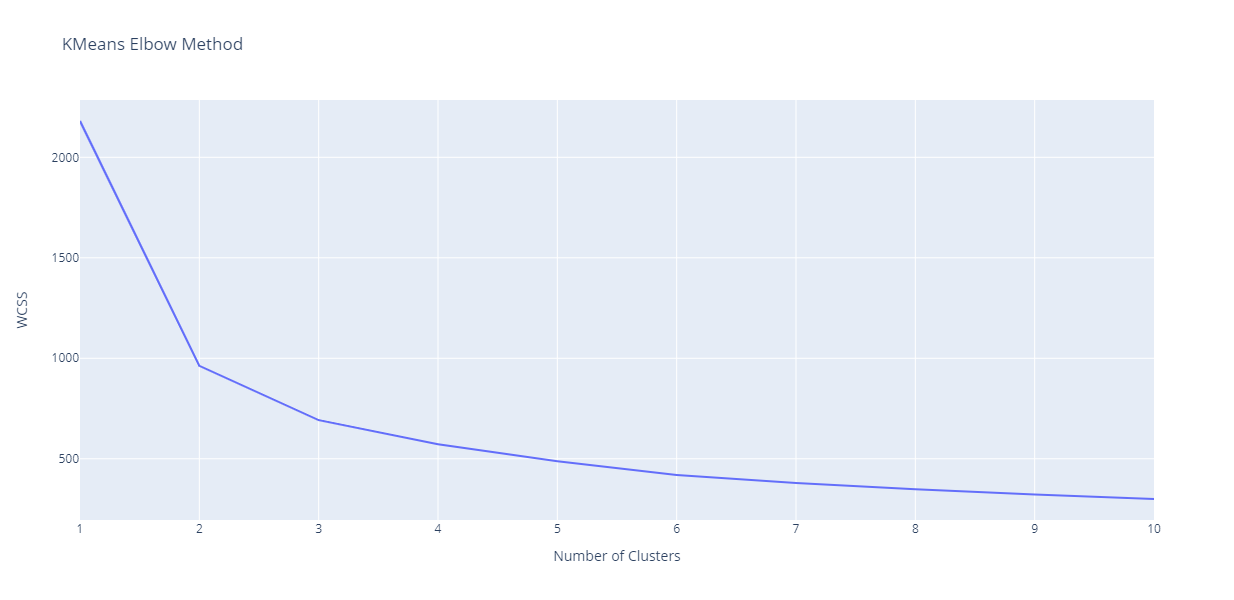

In [26]:
kmeans_wcss(X_pcs_2[:,:3],10)

In [27]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
kmeans.fit(X_pcs_2[:,:3])
y_label = kmeans.predict(X_pcs_2[:,:3])

Cluster3D(X_pcs_2[:,:3],y_label)
print("Silhouette Score:\t",silhouette_score(X_pcs_2[:,:3], y_label))

Silhouette Score:	 0.546009856925256


## Agglomerative Clustering
- The agglomerative clustering is the most common type of hierarchical clustering used to group objects in clusters based on their similarity. 
- It’s also known as AGNES (Agglomerative Nesting). 
- The algorithm starts by treating each object as a singleton cluster. Next, pairs of clusters are successively merged until all clusters have been merged into one big cluster containing all objects. The result is a tree-based representation of the objects, named dendrogram.
- Here the ward's method of clustering is used since it will cluster the data points based on the similarity of variance. Since we have already maximized the within variability of the data using PCA, data points having same variability will be a good metric to form clusters

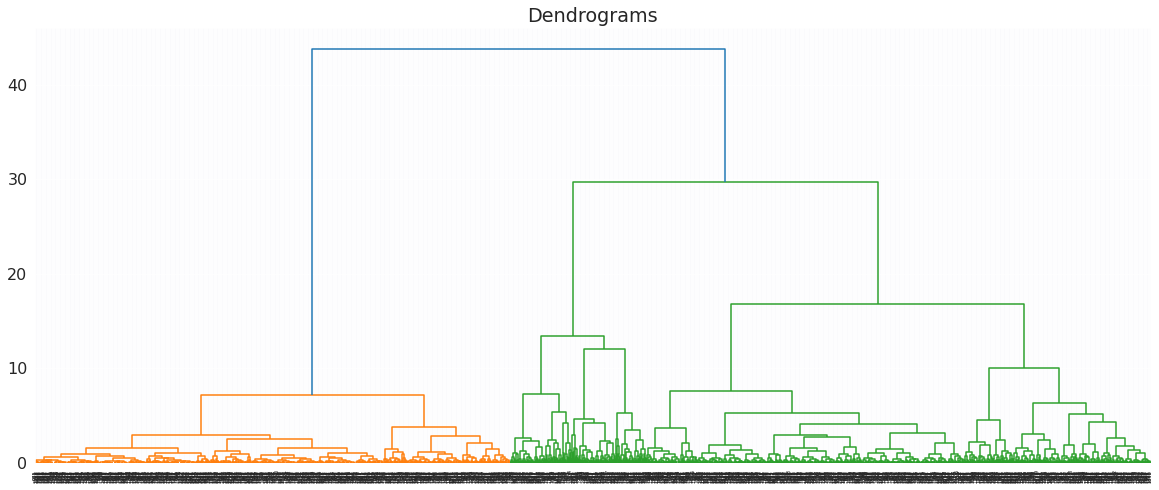

In [28]:
dend = shc.dendrogram(shc.linkage(X_pcs_2[:,:3], method='ward'))
plt.title("Dendrograms")  
plt.show()

In [29]:
clustering = AgglomerativeClustering(linkage='ward').fit(X_pcs_2[:,:3])
y_label = clustering.labels_
Cluster3D(X_pcs_2[:,:3],y_label)
print("Silhouette Score:\t",silhouette_score(X_pcs_2[:,:3], y_label))

Silhouette Score:	 0.3864683186420766


## DBSCAN Clustering
- DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It is a density based clustering algorithm. The algorithm increase regions with sufficiently high density into clusters and finds clusters of arbitrary architecture in spatial databases with noise.

<img src="https://miro.medium.com/proxy/1*tc8UF-h0nQqUfLC8-0uInQ.gif">

In [30]:
pd.DataFrame(X_pcs_2[:,:3]).describe()

,0,1,2
count,1.998000e+03,1.998000e+03,1.998000e+03
mean,-3.556270e-18,-1.333601e-17,-1.644775e-17
std,9.208973e-01,3.675725e-01,3.298560e-01
min,-1.280162e+00,-1.597478e+00,-2.472117e+00
25%,-8.118293e-01,-1.719234e-01,-1.001937e-01
50%,-1.842008e-01,-4.316719e-03,-1.381665e-02
75%,5.393826e-01,1.358771e-01,1.144484e-01
max,3.501399e+00,2.563244e+00,2.491834e+00


In [31]:
X_pcs_2.var(), X_pcs_2.std()

(0.005531085061270922, 0.07437126502400589)

In [38]:
dbscan = DBSCAN(eps=0.8, min_samples=3).fit(X_pcs_2[:,:3])
y_label = dbscan.labels_
Cluster3D(X_pcs_2[:,:3],y_label)
print("Silhouette Score:\t",silhouette_score(X_pcs_2[:,:3], y_label))

Silhouette Score:	 0.6277398941337217


## Mean Shift Clustering
- Mean shift clustering aims to discover “blobs” in a smooth density of samples. It is a centroid-based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region.

<img src="https://spin.atomicobject.com/wp-content/uploads/ms_2d_bw_.8.gif">

In [33]:
clustering = MeanShift().fit(X_pcs_2[:,:3])
y_label = clustering.labels_
Cluster3D(X_pcs_2[:,:3],y_label)
print("Silhouette Score:\t",silhouette_score(X_pcs_2[:,:3], y_label))

Silhouette Score:	 0.489669106028463


| Clustering | Silhouette Score |
| --- | --- |
| **Kmeans on PCA (3PC)** | 0.54 |
| Agglomerative on PCA | 0.386 |
| **DBSCAN on PCA** | 0.627 |
| Mean Shift on PCA | 0.489 |

<p style="font-size:20px;"><strong>Conclusion:</strong> The Silhouette score gives an indication that KMeans algorithm clusters the data really well in terms of separability. DBSCAN has a relatively higher coefficient but the distribution of data in one of the classes is relatively less, as opposed to what we have seen in the ground truth data</p>